In [1]:
import numpy as np
import xarray as xr
import pickle
from hyperopt import fmin, hp, Trials, STATUS_OK
from hyperopt import atpe
import minisom
from importlib import reload
import SOM_functions as functions
reload(functions)
import warnings
from scipy.spatial import cKDTree
from scipy.stats import pearsonr
from scipy.interpolate import griddata
from scipy.optimize import linear_sum_assignment
from sklearn.utils import resample
from scipy.stats import theilslopes
import glob
import os
import cftime
np.warnings = warnings
import pandas as pd
from sklearn.utils import resample
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
from matplotlib.lines import Line2D
import pymannkendall as mk

/home/users/tildah/nb_envs/SOM_env/lib/python3.12/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
ERA5_som = functions.load_som('/home/users/tildah/Internship/CIRCULATION/SOMs/ERA5_som_0.5039677210469622_0.009064451039700279.pkl')
ERA5_nodes = np.load('/home/users/tildah/Internship/CIRCULATION/SOMs/ERA5_best_nodes_0.5039677210469622_0.009064451039700279.npy')
ERA5_zg500_anom = xr.open_dataset('ERA5/ERA5_coords.nc')

#functions.plot_complex(ERA5_som, ERA5_nodes, ERA5_zg500_anom, 4)
#reordered_weights, col_ind, corr_matrix, corr  = functions.reorder_som_to_reference(ERA5_som, old_era5, ERA5_zg500_anom['lat'].values, ERA5_zg500_anom['lon'].values, ERA5_zg500_anom['lat'].values, ERA5_zg500_anom['lon'].values)

models = ['NorESM2-LM','CanESM5', 'MPI-ESM1-2-LR', 'HadGEM3-GC31-LL', 'MIROC6']
experiments = ['historical', 'hist-GHG', 'hist-aer']

#def analyze_som_experiments(models, experiments, era5_som, ERA5_zg500_anom):
results = {}

for model in models:
    results[model] = {}
    for exp in experiments:
        print(model, exp)
        # -----------------------------
        # 1. Load SOM, node assignments, and coordinates
        # -----------------------------
        # Find training parameters dynamically if needed
        # Path pattern to SOM files for this model/experiment
        som_pattern = f'SOMs/{model}_{exp}_som_*.pkl'
        som_files = glob.glob(som_pattern)
        
        if len(som_files) == 0:
            raise FileNotFoundError(f"No SOM file found for {model} {exp}")
        elif len(som_files) > 1:
            raise ValueError(f"Multiple SOM files found for {model} {exp}, expected only one.")
        
        # Extract training parameters from filename
        som_filename = os.path.basename(som_files[0])  # e.g., "MODEL_EXP_som_sigma0.5_lr0.1.pkl"
        training_parameters = som_filename.split('_som_')[1].replace('.pkl', '')
        som = functions.load_som(f'SOMs/{model}_{exp}_som_{training_parameters}.pkl')
        best_nodes = np.load(f'SOMs/{model}_{exp}_best_nodes_{training_parameters}.npy')
        coords_ds = xr.open_dataset(f'~/Internship/CIRCULATION/data_train/{model}_{exp}coords.nc')
        times = coords_ds['time'].values

        # -----------------------------
        # 2. Reorder SOM to ERA5 reference
        # -----------------------------
        reordered_weights, col_ind, corr_matrix, matched_corrs = functions.reorder_som_to_reference(
            som, ERA5_som, coords_ds['lat'].values, coords_ds['lon'].values, ERA5_zg500_anom['lat'].values, ERA5_zg500_anom['lon'].values)
        #print(col_ind)
        #print(best_nodes)
        # Update node assignments to ERA5 order
        best_nodes_era5 = np.array([col_ind[idx] for idx in best_nodes])
        #print(best_nodes_era5)

        # -----------------------------
        # 3. Identify ensemble member start indices
        # -----------------------------
        years = np.array([
            t.year if isinstance(t, (cftime.DatetimeNoLeap, cftime.DatetimeGregorian)) else int(str(t)[:4])
            for t in times
        ])
        ensemble_starts = np.insert(np.where(np.diff(years) < 0)[0] + 1, 0, 0)
        ensemble_ends   = np.append(ensemble_starts[1:] - 1, len(times) - 1)
        n_nodes = reordered_weights.shape[0]
        
        # Store per-member trends
        trends_1940_1979 = np.zeros((len(ensemble_starts), n_nodes))
        trends_1980_2014 = np.zeros((len(ensemble_starts), n_nodes))
        p_value_1940_1979 = np.zeros((len(ensemble_starts), n_nodes))
        p_value_1980_2014 = np.zeros((len(ensemble_starts), n_nodes))
        
        # -----------------------------
        # 4-5. Calculate 5-year running averages and trends per ensemble member
        # -----------------------------
        for e, (start, end) in enumerate(zip(ensemble_starts, ensemble_ends)):
            member_nodes = best_nodes_era5[start:end+1]
            member_times = times[start:end+1]
        
            # Put into DataFrame
            df = pd.DataFrame({"time": member_times, "node": member_nodes})
        
            if hasattr(df["time"].iloc[0], "year"):
                df["year"] = [t.year for t in df["time"]]
            else:
                df["year"] = pd.to_datetime(df["time"]).dt.year
        
            # Count node occurrences per year
            hw_node_counts = df.groupby(["year", "node"]).size().unstack(fill_value=0)
        
            # Reindex to fixed range of years
            all_years = list(range(1940, 2015))
            node_counts_per_year = hw_node_counts.reindex(all_years, fill_value=0)
        
            # 5-year running average
            window = 5
            
            node_counts_np = node_counts_per_year.values
        
            node_counts_5yr = np.array([
                np.convolve(node_counts_np[:, i], np.ones(window)/window, mode="valid")
                for i in range(node_counts_np.shape[1])
            ]).T
        
            year_range = np.arange(all_years[0], all_years[-1]+1)
            yr_mid = year_range[(window-1)//2 : -(window-1)//2 or None]
        
            mask1 = (yr_mid >= 1942) & (yr_mid <= 1979)
            mask2 = (yr_mid >= 1980) & (yr_mid <= 2012)
        
            for node in range(n_nodes):
                # Period 1
                yvals = node_counts_5yr[mask1, node]
                xvals = yr_mid[mask1]
                if len(yvals) > 0:
                    slope, _, _, _ = theilslopes(yvals, xvals)
                    trends_1940_1979[e, node] = slope
                    mk_result = mk.original_test(yvals)
                    p_value_1940_1979[e, node] = mk_result.p
        
                # Period 2
                yvals = node_counts_5yr[mask2, node]
                xvals = yr_mid[mask2]
                if len(yvals) > 0:
                    slope, _, _, _ = theilslopes(yvals, xvals)
                    trends_1980_2014[e, node] = slope
                    mk_result = mk.original_test(yvals)
                    p_value_1980_2014[e, node] = mk_result.p
        
        # -----------------------------
        # 6. Ensemble mean and bootstrap across ensemble members
        # -----------------------------
        mean_trend_1940_1979 = np.nanmean(trends_1940_1979, axis=0)* 10
        mean_trend_1980_2014 = np.nanmean(trends_1980_2014, axis=0)* 10

        n_boot = 1000
        for node in range(n_nodes):
            # Bootstrap across ensemble members
            slopes_bs1 = [np.mean(resample(trends_1940_1979[:, node])) for _ in range(n_boot)]
            slopes_bs2 = [np.mean(resample(trends_1980_2014[:, node])) for _ in range(n_boot)]
        
        # -----------------------------
        # 7. Save results to dictionary
        # -----------------------------

        results[model][exp] = {
            'pattern_corr': matched_corrs,
            'n_ensembles': len(ensemble_starts),
            "mean_trend_1940-1979": mean_trend_1940_1979,
            "mean_trend_1980-2014": mean_trend_1980_2014,
            "per_member_trends_1940-1979": trends_1940_1979,
            "per_member_trends_1980-2014": trends_1980_2014,
            "per_member_significance_1940-1979": p_value_1940_1979,
            "per_member_significance_1980-2014": p_value_1980_2014
        }

NorESM2-LM historical
NorESM2-LM hist-GHG
NorESM2-LM hist-aer
CanESM5 historical
CanESM5 hist-GHG
CanESM5 hist-aer
MPI-ESM1-2-LR historical
MPI-ESM1-2-LR hist-GHG
MPI-ESM1-2-LR hist-aer
HadGEM3-GC31-LL historical
HadGEM3-GC31-LL hist-GHG
HadGEM3-GC31-LL hist-aer
MIROC6 historical
MIROC6 hist-GHG
MIROC6 hist-aer


In [3]:
# PUTS LOW PATTERN CORRELATIONS TO NAN
for model, exps in results.items():
    for exp, data in exps.items():
        # Extract pattern correlations
        pattern_corr = data['pattern_corr']

        bad_nodes = np.where(pattern_corr < 0.4)[0]

        # Replace trends & cis with NaN at those indices
        for node in bad_nodes:
            print(model, exp, node)
            # Mean trends
            data['mean_trend_1940-1979'][node] = np.nan
            data['mean_trend_1980-2014'][node] = np.nan

            # Per-member
            data['per_member_trends_1940-1979'][:, node] = np.nan
            data['per_member_trends_1980-2014'][:, node] = np.nan
            data['per_member_significance_1940-1979'][:, node] = np.nan
            data['per_member_significance_1980-2014'][:, node] = np.nan

#print(results['NorESM2-LM']['historical'])

NorESM2-LM historical 3
NorESM2-LM hist-GHG 3
NorESM2-LM hist-aer 3
HadGEM3-GC31-LL hist-GHG 1
HadGEM3-GC31-LL hist-GHG 2
HadGEM3-GC31-LL hist-aer 0
MIROC6 hist-aer 0


In [4]:
for model, exps in results.items():
    for exp, data in exps.items():
        mod = data['per_member_trends_1980-2014']
        if model == "HadGEM3-GC31-LL" and exp == "historical":
            print(mod)
            col_means = np.nanmean(mod, axis=0)
            print(col_means)

[[0.15192308 0.4        0.2        0.02792208]
 [0.12679426 0.17391304 0.22111111 0.10438095]
 [0.06       0.29372549 0.31055556 0.12403846]
 [0.08888889 0.11155556 0.24       0.10480549]
 [0.17287356 0.26103448 0.24       0.16666667]]
[0.12009596 0.24804571 0.24233333 0.10556273]


In [6]:
# MMM  as with plot 2 (5.11.25)
# CONFIDENCE NOT CALCULATED BUT CAN BE USING PER MEMBER TRENDS IN RESULTS

n_nodes = 4

# --- prepare experiments list (exclude ERA5 observational entry if present) ---
all_models = list(results.keys())
experiments = sorted({exp for m in all_models for exp in results[m].keys()})
# remove ERA5 if accidentally present in results
if "ERA5" in experiments:
    experiments.remove("ERA5")


n_boot = 1000

# containers
ci_by_exp = {exp: {"1940-1979": np.full((n_nodes, 2), np.nan),
                   "1980-2014": np.full((n_nodes, 2), np.nan)}
             for exp in experiments}

mean_by_exp = {exp: {"1940-1979": np.full(n_nodes, np.nan),
                     "1980-2014": np.full(n_nodes, np.nan)}
               for exp in experiments}


# Loop over experiments
for exp in experiments:
    # Prepare to collect model-mean trends
    trends_1940 = []
    trends_1980 = []

    for model in results:
        entry = results[model][exp]

        # Get ensemble-averaged trends from this model
        trend_1940 = entry.get("mean_trend_1940-1979")
        trend_1980 = entry.get("mean_trend_1980-2014")

        trends_1940.append(trend_1940)
        trends_1980.append(trend_1980)

    # Compute the model-mean (multi-model mean of ensemble means)
    mean_by_exp[exp]["1940-1979"] = np.nanmean(np.stack(trends_1940), axis=0)
    mean_by_exp[exp]["1980-2014"] = np.nanmean(np.stack(trends_1980), axis=0)

print(mean_by_exp)

{'hist-GHG': {'1940-1979': array([0.15133778, 0.16232275, 0.21916176, 0.31707284]), '1980-2014': array([1.39324519, 1.12858699, 0.80526914, 0.97989133])}, 'hist-aer': {'1940-1979': array([-0.54671998, -0.7623716 , -0.67972691, -0.66282867]), '1980-2014': array([0.25938443, 0.21493586, 0.03563968, 0.27007688])}, 'historical': {'1940-1979': array([-0.14703299, -0.21660575, -0.17627927, -0.14750664]), '1980-2014': array([1.74729398, 1.39634917, 1.56265735, 1.76785185])}}


In [7]:
def calculate_ERA5_trends(ERA5_nodes, ERA5_times, n_nodes=4):
    # Create dataframe with time + assigned node
    df = pd.DataFrame({"time": ERA5_times, "node": ERA5_nodes})
    
    # Extract years
    if hasattr(df["time"].iloc[0], "year"):
        df["year"] = [t.year for t in df["time"]]
    else:
        df["year"] = pd.to_datetime(df["time"]).dt.year
    
    # Count node occurrences per year
    hw_node_counts = df.groupby(["year", "node"]).size().unstack(fill_value=0)
    
    # Reindex to fixed years
    all_years = list(range(1940, 2015))
    node_counts_per_year = hw_node_counts.reindex(all_years, fill_value=0)
    
    # 5-year running mean
    window = 5
    node_counts_np = node_counts_per_year.values
    node_counts_5yr = np.array([
        np.convolve(node_counts_np[:, i], np.ones(window)/window, mode="valid")
        for i in range(node_counts_np.shape[1])
    ]).T
    
    year_range = np.arange(all_years[0], all_years[-1] + 1)
    yr_mid = year_range[(window - 1)//2 : -(window - 1)//2 or None]
    
    # Masks for periods
    mask1 = (yr_mid >= 1942) & (yr_mid <= 1979)
    mask2 = (yr_mid >= 1980) & (yr_mid <= 2012)
    
    # Store results
    results = []
    sig_results =[]
    for node in range(n_nodes):
        # Period 1
        yvals = node_counts_5yr[mask1, node]
        xvals = yr_mid[mask1]
        if len(yvals) > 0:
            slope, _, _, _ = theilslopes(yvals, xvals)
            mk_result = mk.original_test(yvals)
            p_value = mk_result.p
            results.append({"Node": node, "Period": "1940-1979", "Slope": slope})
            sig_results.append({"Node": node, "Period": "1940-1979", "p_value": p_value})
        
        # Period 2
        yvals = node_counts_5yr[mask2, node]
        xvals = yr_mid[mask2]
        if len(yvals) > 0:
            slope, _, _, _ = theilslopes(yvals, xvals)
            mk_result = mk.original_test(yvals)
            p_value = mk_result.p
            results.append({"Node": node, "Period": "1980-2014", "Slope": slope})
            sig_results.append({"Node": node, "Period": "1980-2014", "p_value": p_value})
    
    # Convert to DataFrame with MultiIndex
    trend_results = pd.DataFrame(results).set_index(["Node", "Period"])
    sig_results = pd.DataFrame(sig_results).set_index(["Node", "Period"])
    return trend_results, sig_results

# --- run it ---
trend_results_ERA5, sig_results_ERA5 = calculate_ERA5_trends(ERA5_nodes, ERA5_zg500_anom.time.values, n_nodes=4)
era5_trends = (
    trend_results_ERA5["Slope"]      # take the slope column
    .unstack("Period")               # columns: "1940-1979", "1980-2014"
    .reindex(range(n_nodes))   # ensure Node order 0..n-1
    * 10                             # convert to days/decade
)

time_series, node_freqs = functions.hw_time_series(ERA5_zg500_anom, ERA5_nodes)
smoothed_time_series = time_series.rolling(window=5, center=True, min_periods=1).mean()
smoothed_time_series = smoothed_time_series[2:-2]

print(era5_trends)

print(sig_results_ERA5)

Period  1940-1979  1980-2014
Node                        
0       -0.352941   3.297059
1       -0.210526   2.316770
2        0.137931   1.169856
3        0.111111   1.822134
                     p_value
Node Period                 
0    1940-1979  3.667219e-05
     1980-2014  8.051274e-09
1    1940-1979  4.610826e-03
     1980-2014  1.050805e-06
2    1940-1979  7.822210e-02
     1980-2014  1.514500e-04
3    1940-1979  4.403051e-01
     1980-2014  4.877532e-04


In [19]:
#print(time_series[20:])

NorESM2-LM hist-GHG 1940-1979 [0.12254778 0.23160034 0.21736694        nan]
NorESM2-LM hist-GHG 1980-2014 [0.48726012 0.58952859 0.34142575        nan]
NorESM2-LM hist-aer 1940-1979 [-1.05893028 -0.47374668 -0.73880565         nan]
NorESM2-LM hist-aer 1980-2014 [0.18232976 0.11751065 0.02350427        nan]
NorESM2-LM historical 1940-1979 [-0.24823256 -0.35366162 -0.21940305         nan]
NorESM2-LM historical 1980-2014 [1.57231807 1.33710299 1.00974119        nan]
CanESM5 hist-GHG 1940-1979 [ 0.05826     0.05457431 -0.01335714  0.13893811]
CanESM5 hist-GHG 1980-2014 [1.89637299 2.21663592 1.25493301 0.44870702]
CanESM5 hist-aer 1940-1979 [-0.32507405 -0.56256549 -0.6959482  -0.61940677]
CanESM5 hist-aer 1980-2014 [0.33536075 0.43835116 0.2926317  0.10104238]
CanESM5 historical 1940-1979 [ 0.01269742 -0.01447154 -0.00998007 -0.00533333]
CanESM5 historical 1980-2014 [3.2628602  0.12656816 1.80210203 3.28933219]
MPI-ESM1-2-LR hist-GHG 1940-1979 [0.2499417  0.2202592  0.24089121 0.31803337]

/tmp/ipykernel_5818/1825611543.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


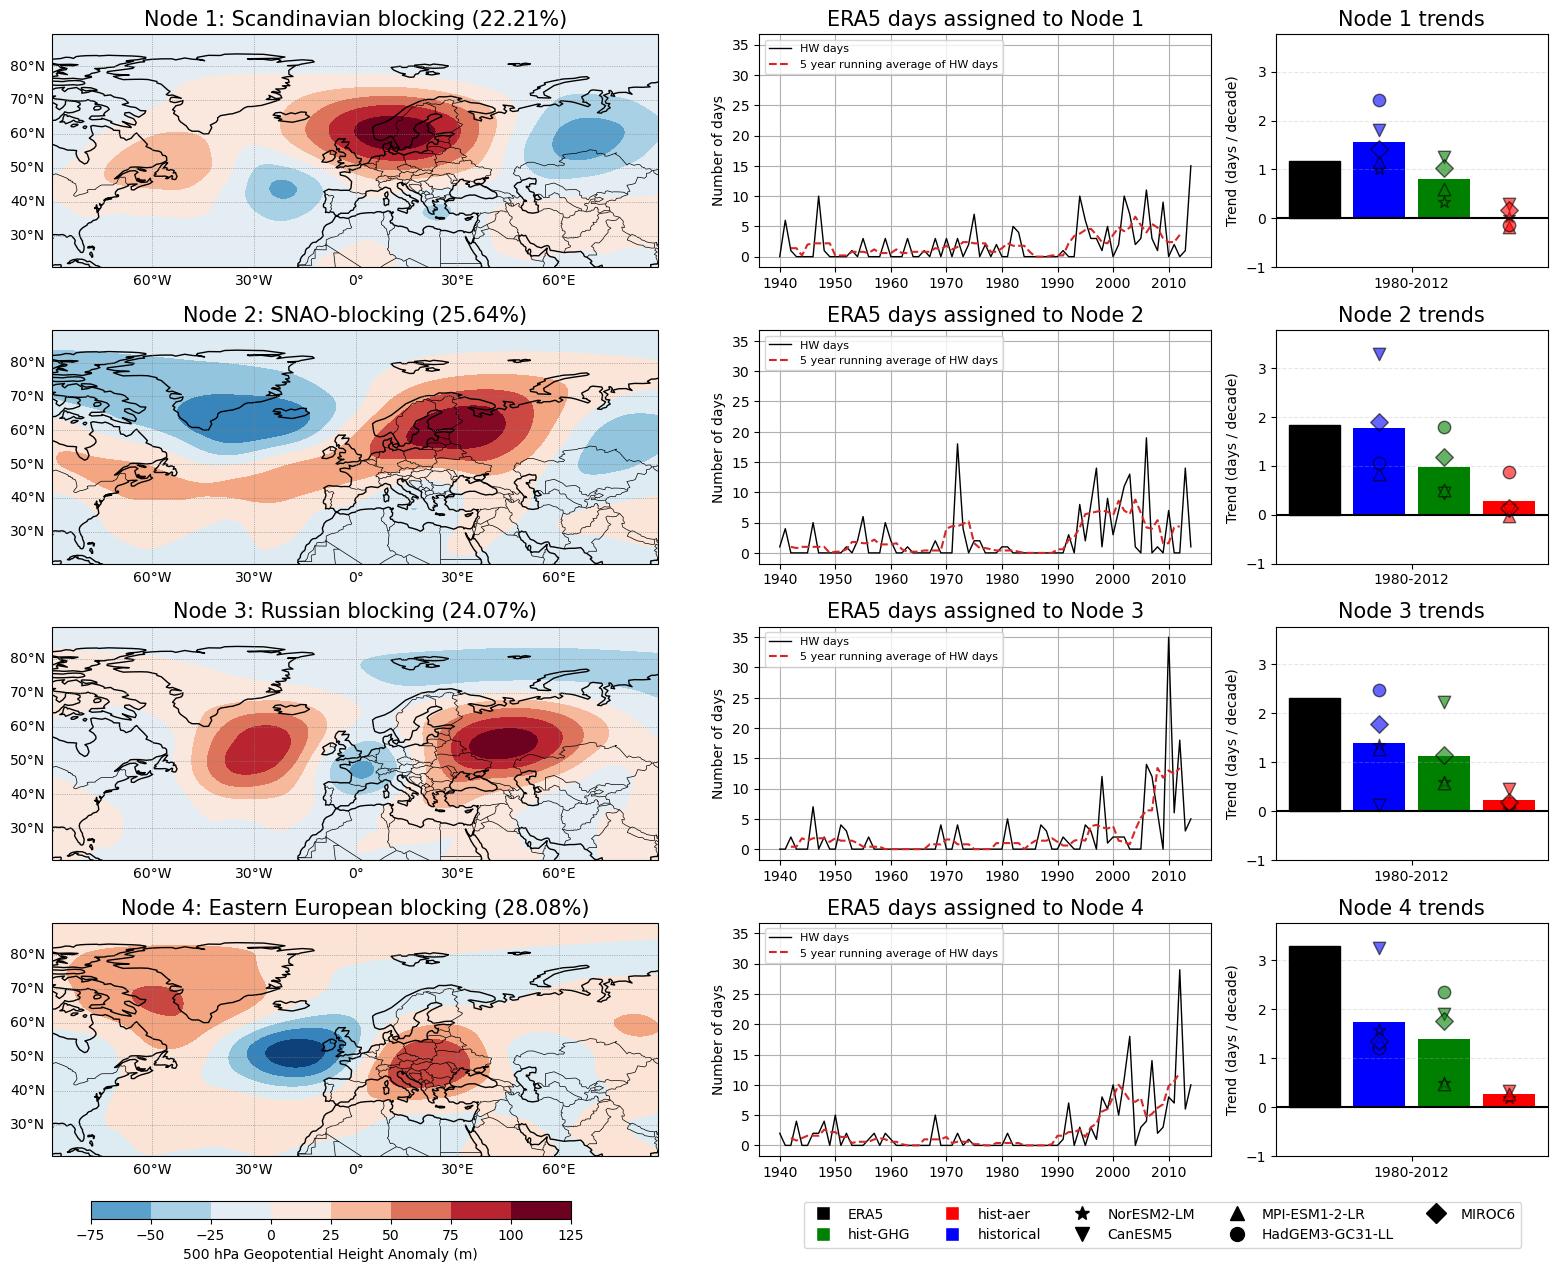

In [8]:
node_titles = ["Scandinavian blocking", "SNAO-blocking", "Russian blocking", "Eastern European blocking"]

lat_size = len(ERA5_zg500_anom.lat)
lon_size = len(ERA5_zg500_anom.lon)
years = np.arange(1940, 2015)
n_nodes = 4

# Define figure size and grid layout (3 columns: SOM, time series, bar chart)
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(nrows=n_nodes, ncols=3, 
                       width_ratios=[0.3, 0.2, 0.12], height_ratios=[1] * n_nodes)

# Create axes lists
som_axes = []
time_series_axes = []
bar_axes = []

node_order = [2, 3, 1, 0]  # custom order for 4 nodes

for i, node in enumerate(node_order):
    # SOM plots (Column 1)
    ax_som = fig.add_subplot(gs[i, 0], projection=ccrs.PlateCarree())
    som_axes.append(ax_som)

    # Time series plots (Column 2)
    ax_ts = fig.add_subplot(gs[i, 1])
    time_series_axes.append(ax_ts)

    # Bar chart plots (Column 3)
    ax_bar = fig.add_subplot(gs[i, 2])
    bar_axes.append(ax_bar)

colors = {"ERA5": "black", "historical": "blue", "hist-GHG": "green", "hist-aer": "red"}
periods = ["1940-1979", "1980-2014"]
custom_labels = {"1940-1979": "1942–1979", "1980-2014": "1980–2012"}
MARKERS = {
    "HadGEM3-GC31-LL": "o", "ERA5": "X", "CMCC-CM2-SR5": "s",
    "MPI-ESM1-2-LR": "^", "MIROC6": "D", "CanESM5": "v",
    "ACCESS-ESM1-5": "P", "NorESM2-LM": "*"
}
# Plot SOM patterns and time series

for i, ax in enumerate(som_axes):
    node = node_order[i]
    percentage = ((ERA5_nodes == node).sum() / len(ERA5_nodes))*100
    # Plot SOM patterns (Z500 anomalies)
    som_pattern = ERA5_som._weights[node, 0].reshape(lat_size, lon_size) / 9.81
    vmin, vmax = -abs(som_pattern).max(), abs(som_pattern).max()
    im = ax.contourf(ERA5_zg500_anom.lon, ERA5_zg500_anom.lat, som_pattern, cmap="RdBu_r", 
                     transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
    
    # Add coastlines and borders
    ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor="black")
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor="black")
    gridlines = ax.gridlines(draw_labels=True, linestyle=":", linewidth=0.5, color="grey")
    gridlines.top_labels = False
    gridlines.bottom_labels = True 
    gridlines.left_labels = True 
    gridlines.right_labels = False


    # Set SOM node titles with heatwave stats
    ax.set_title(f"Node {i+1}: {node_titles[i]} ({percentage:.2f}%)", fontsize=15)
    
    # Add colorbar to the first SOM plot
    if i == 0:
        cax = fig.add_axes([0.08, -0.02, 0.3, 0.015])  # [left, bottom, width, height]
        cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
        cbar.set_label('500 hPa Geopotential Height Anomaly (m)')

# Precompute consistent y-axis limits
y1_min = time_series.min().min()
y1_max = time_series.max().max()

# Optional: expand limits slightly for aesthetics
pad1 = 0.05 * (y1_max - y1_min)
y1_min -= pad1
y1_max += pad1

# Plot time series with twin y-axis for each node
for i, ax in enumerate(time_series_axes):
    node = node_order[i]
    ax.plot(years, time_series.iloc[:, node], label='HW days', color='black', linestyle='-', linewidth = 1)
    ax.plot(years[2:-2], smoothed_time_series.iloc[:, node], label='5 year running average of HW days', color='tab:red', linestyle='--')
    ax.set_ylabel("Number of days")
    ax.set_ylim(y1_min, y1_max)
    ax.tick_params(axis='y')
    ax.grid(True)
    ax.set_title(f'ERA5 days assigned to Node {i+1}', fontsize=15)
    ax.legend(fontsize=8, loc="upper left")

# SCATTER PLOT IN BAR_AXES COLUMN
# First compute global ymin, ymax across all nodes/periods/experiments
all_vals = []
for model in results.keys():
    for exp in experiments:
        for p in periods:
            slopes = results[model][exp].get(f"mean_trend_{p}", None)
            print(model, exp, p, slopes)
            if slopes is not None:
                all_vals.extend(slopes[~np.isnan(slopes)])

ymin, ymax = np.min(all_vals), np.max(all_vals)
pad = 0.1 * (ymax - ymin)  # add a little padding
ymin, ymax = ymin - pad, ymax + pad

# BAR PLOT
# BAR PLOT - show only the latter period in the centre of each chart
for i, ax in enumerate(bar_axes):
    node = node_order[i]

    # We'll only plot the last period
    p_last = periods[-1]

    # Build x positions for the single period so groups are centred
    x_map, centers = {}, []
    order = ["ERA5"] + list(colors.keys())   # same order you used before
    start = 0                                # single block, start at 0
    centers.append(start + (len(order)) / 2)

    for k, exp in enumerate(order):
        x_map[(exp, p_last)] = start + k

    # Collect values per experiment-period but only for the latter period
    mean_trends = defaultdict(list)
    for model in results.keys():
        for exp in experiments:
            # only use p_last here
            slopes = results[model][exp].get(f"mean_trend_{p_last}", None)
            val = slopes[node]
            mean_trends[(exp, p_last)].append(val)

    # --- Bars for MMM (only latter period) ---
    for exp in experiments:
        xpos = x_map[(exp, p_last)]
        mean_val = mean_by_exp[exp][p_last][node]
        ax.bar(xpos, mean_val, color=colors.get(exp, "gray"), width=0.8, zorder=1)

    # --- ERA5 (only latter period) ---
    xpos = x_map[("ERA5", p_last)]
    y = era5_trends[p_last][node]
    ax.bar(xpos, y, color="black", edgecolor="black", width=0.8, zorder=3)

    # --- Scatter for individual models (only latter period) ---
    for (exp, p), vals in mean_trends.items():
        # p will always equal p_last here
        xpos = x_map[(exp, p)]
        for model_val, model in zip(vals, results.keys()):
            ax.scatter(xpos, model_val,
                       marker=MARKERS.get(model, "o"),
                       color=colors.get(exp, "black"),
                       edgecolor="black",
                       alpha=0.6,
                       s=80,
                       zorder=2)

    # Add horizontal zero line
    ax.axhline(0, c="k", lw=1.5)

    # --- Fix y-limits across all nodes ---
    ax.set_ylim(-1, ymax)
    ax.set_xticks(centers)
    ax.set_xticklabels(["1980-2012"])
    ax.set_ylabel("Trend (days / decade)")
    ax.set_title(f"Node {i+1} trends", fontsize=15)
    ax.grid(axis='y', ls='--', alpha=0.3)

model_legend = [Line2D([0], [0], marker=MARKERS[m], color='w', label=m,
                       markerfacecolor='black', markeredgecolor='black', markersize = 10)
                       for m in list(results.keys())]
exp_legend = [Line2D([0], [0], marker='s', color='w', label=e,
                     markerfacecolor=colors.get(e, 'k'), markersize = 10)
                     for e in ["ERA5"] + experiments]

# Single shared legend below plots
fig.legend(handles=exp_legend + model_legend, loc='lower center', ncol=5, bbox_to_anchor=(0.75, -0.05)) # (left/bottom, right/top)

#plt.subplots_adjust(wspace=0.25, hspace=0.25) 
plt.tight_layout()
plt.savefig('circulation_plot_18.11.25.jpg', bbox_inches='tight', pad_inches=0.2, dpi=300)
plt.show()


In [ ]:
# BAR PLOT for 2 periods
for i, ax in enumerate(bar_axes):
    node = node_order[i]
    x_map, centers = {}, []
    for j, p in enumerate(periods):
        order = ["ERA5"] + list(colors.keys())
        start = j * (len(order) + 1)
        centers.append(start + (len(order) - 1) / 2)
        for k, exp in enumerate(order):
            x_map[(exp, p)] = start + k

    # Collect values per experiment-period
    mean_trends = defaultdict(list)
    for model in results.keys():
        for exp in experiments:
            for p in periods:
                slopes = results[model][exp].get(f"mean_trend_{p}", None)
                val = slopes[node]
                mean_trends[(exp, p)].append(val)

    # --- Bars for MMM ---
    for exp in experiments:
        for p in periods:
            xpos = x_map[(exp, p)]
            mean_val = mean_by_exp[exp][p][node]
            ax.bar(xpos, mean_val, color=colors.get(exp, "gray"), width=0.8, zorder=1)


    # --- ERA5 ---
    for p in periods:
        xpos = x_map[("ERA5", p)]
        y = era5_trends[p][node]
        ax.bar(xpos, y, color="black", edgecolor="black", width=0.8, zorder=3)

    # --- Scatter for individual models ---
    for (exp, p), vals in mean_trends.items():
        xpos = x_map[(exp, p)]
        for model_val, model in zip(vals, results.keys()):
               # print(node, exp, model, model_val)
            ax.scatter(xpos, model_val,  
                       marker=MARKERS.get(model, "o"), 
                       color=colors.get(exp, "black"),
                       edgecolor="black",
                       alpha = 0.5,
                       s=80,
                       zorder=2)

    # Add horizontal zero line + vertical dividers
    ax.axhline(0, c="k", lw=1.5)
    for j in range(1, len(periods)):
        ax.axvline(j * (len(experiments) + 2.5), c="k", ls=":")
